* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from scipy.stats import bartlett
from scipy.stats import levene
import seaborn as sns
%matplotlib inline

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'
                       .format(postgres_user, postgres_pw, postgres_host,
                              postgres_port, postgres_db))

df = pd.read_sql_query('SELECT * FROM weatherinszeged', con=engine)

engine.dispose()

In [3]:
df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
#ensuring that there are no mssing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [5]:
print(df['summary'].unique())
print('--------------------')
print(df['preciptype'].unique())
print('--------------------')
print(df['dailysummary'].unique())

['Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Foggy'
 'Breezy and Mostly Cloudy' 'Clear' 'Breezy and Partly Cloudy'
 'Breezy and Overcast' 'Humid and Mostly Cloudy' 'Humid and Partly Cloudy'
 'Windy and Foggy' 'Windy and Overcast' 'Breezy and Foggy'
 'Windy and Partly Cloudy' 'Breezy' 'Dry and Partly Cloudy'
 'Windy and Mostly Cloudy' 'Dangerously Windy and Partly Cloudy' 'Dry'
 'Windy' 'Humid and Overcast' 'Light Rain' 'Drizzle' 'Windy and Dry'
 'Dry and Mostly Cloudy' 'Breezy and Dry' 'Rain']
--------------------
['rain' 'snow' 'null']
--------------------
['Partly cloudy throughout the day.' 'Mostly cloudy throughout the day.'
 'Foggy in the evening.' 'Foggy overnight and breezy in the morning.'
 'Overcast throughout the day.' 'Partly cloudy until night.'
 'Mostly cloudy until night.'
 'Foggy starting overnight continuing until morning.'
 'Foggy in the morning.' 'Partly cloudy until evening.'
 'Partly cloudy starting in the morning.'
 'Mostly cloudy starting overnight continuing unti

In [6]:
#we can see above that the 'dailysummary' column contains a lot of redundant information and does not give us anything new
#that is present in the 'summary' and 'preciptype' columns. 
#We will drop this column so that we don't one-hot-encode this information
df = df.drop('dailysummary', axis=1)

df_o_h_encoded = pd.get_dummies(df, drop_first=True)

df_o_h_encoded.head()

,date,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,summary_Breezy and Dry,...,summary_Partly Cloudy,summary_Rain,summary_Windy,summary_Windy and Dry,summary_Windy and Foggy,summary_Windy and Mostly Cloudy,summary_Windy and Overcast,summary_Windy and Partly Cloudy,preciptype_rain,preciptype_snow
0,2006-03-31 22:00:00+00:00,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,0,...,1,0,0,0,0,0,0,0,1,0
1,2006-03-31 23:00:00+00:00,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,0,...,1,0,0,0,0,0,0,0,1,0
2,2006-04-01 00:00:00+00:00,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,0,...,0,0,0,0,0,0,0,0,1,0
3,2006-04-01 01:00:00+00:00,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,0,...,1,0,0,0,0,0,0,0,1,0
4,2006-04-01 02:00:00+00:00,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
df_o_h_encoded.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,summary_Breezy and Dry,summary_Breezy and Foggy,...,summary_Partly Cloudy,summary_Rain,summary_Windy,summary_Windy and Dry,summary_Windy and Foggy,summary_Windy and Mostly Cloudy,summary_Windy and Overcast,summary_Windy and Partly Cloudy,preciptype_rain,preciptype_snow
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000,96453.00000,96453.000000,...,96453.000000,96453.000000,96453.000000,96453.00000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956,0.00001,0.000363,...,0.329000,0.000104,0.000083,0.00001,0.000041,0.000363,0.000467,0.000695,0.883581,0.111059
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906,0.00322,0.019046,...,0.469852,0.010182,0.009107,0.00322,0.006440,0.019046,0.021595,0.026347,0.320729,0.314207
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000,0.00000,0.000000,...,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#assigning target variable
Y = df_o_h_encoded['temperature']

#assigning explanatory variables
X = df_o_h_encoded[['humidity', 'windspeed', 'windbearing', 'pressure']]

#fitting linear regregression to target variable and explanatory variables
#and estimating parameters via OLS
lrm = linear_model.LinearRegression() 
lrm.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
#examining coefficients and intercept of model we fit to our variables
print(lrm.coef_)
print(lrm.intercept_)

[-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]
37.92643818528529


Assumption 1: Linearity of the model in its coefficients. 

Our model meets this assumption as we are not squaring or divinding any of our coefficients. All the coefficients are constant across changing independent and depenedent variables. 

Assumption 2: the error term should be zero on average, which we can see below is the case.

In [10]:
predictions = lrm.predict(X)
errors = Y - predictions
print(errors.sum())

-9.458744898438454e-11


Assumption 3: Homoscedasticity

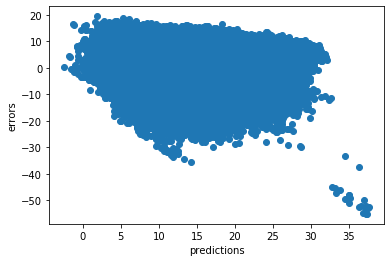

In [11]:
plt.scatter(predictions, errors)
plt.xlabel('predictions')
plt.ylabel('errors')
plt.show()

In [12]:
bartlett_stats = bartlett(predictions, errors)
levene_stats = levene(predictions, errors)

print("Bartlett test statistic value is {} and p value is {}".format(bartlett_stats[0], bartlett_stats[1]))
print("Levene test statistic value is {} and p value is {}".format(levene_stats[0], levene_stats[1]))

Bartlett test statistic value is 2464.8446568676018 and p value is 0.0
Levene test statistic value is 2321.2401008575416 and p value is 0.0


In both cases we can see that the p-value is zero. This means that we can reject the null hypothesis which is that our model is Homoscedastic. Therefore we know that it is Heteroscedastic, as is confirmed by visual inspection of the above plot. 

Having a Heteroscedastic model means that the variance systematically changes depending upon the observations. We should expect that this will lead to overconfidence in the accuracy of our model's predictions. We also know that we may face problems when it comes to the reliability of some statistical tests like the t-test and the F-test. Heteroscedasticity may also make some estimated coefficients seem more statistically significant. 

Assumption 4: Low multicollinearity 

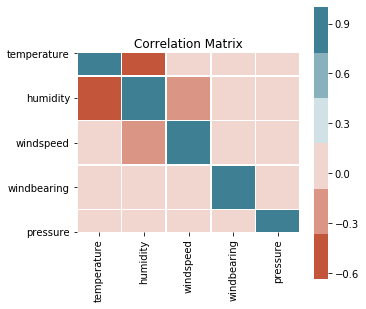

In [13]:
co_lin_df = pd.DataFrame()
co_lin_df = df[['temperature','humidity', 'windspeed', 'windbearing', 'pressure']]

fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(
    co_lin_df.corr(), 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    linewidths=.5).set_title('Correlation Matrix')

In [14]:
co_lin_df.corr()['temperature']['humidity']

-0.6322546750277743

In [15]:
co_lin_df.corr()['windspeed']['humidity']

-0.22495145587976773

From the heatmap of our correlation matrix we can see that there is no issue when it comes to co-linearity for our features. We can see the largest correlation exists between humidity and temperature which is only around -0.63. This is not important as temperature is our target variuable. Outside of this we have only -.22 correlation between windspeed and humidity which is not very high. 

Assumption 5: Error terms should be uncorrelated with one another

plt.plot(errors)
plt.show()

In [17]:
acf_data = acf(errors)

c:\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


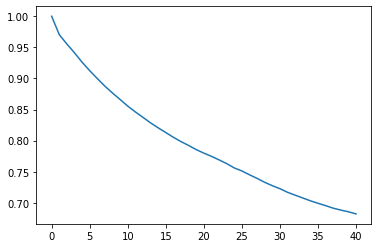

In [20]:
plt.plot(acf_data)
plt.show()

It appears from the chart above that we do have a structure correlation to our errors. Meaning that they steadily decrease as we increase in our temperature value prediction. This could likely be caused by an important variable that was left out of our feature list. 

Assumption 6: Features shouldn't be correlated with the errors

In [21]:
co_lin_df['errors'] = errors

c:\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


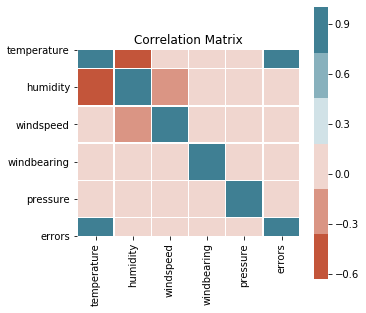

In [22]:
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(
    co_lin_df.corr(), 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    linewidths=.5).set_title('Correlation Matrix')

We can see that temperature is highly correlated with errors. However this is a problem that was previously discussed. The features that we use in are model are not correlated with the errors. 